# Customer Purchase Behavior Clustering
- This notebook performs clustering on customer purchase behavior data to identify distinct purchase patterns.

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
import joblib,os

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import seaborn as sns
# pca
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score



In [28]:

purchase_behavior_features = [
    'NumDealsPurchases',  # Promo purchases
    'NumWebPurchases',  # Online
    'NumCatalogPurchases',  # Catalog
    'NumStorePurchases',  # In-store
    'NumWebVisitsMonth'  # Website visits (optional: inverse indicator)
]

df = pd.read_csv('../featured_customer_segmentation.csv')
# Display the first few rows of the DataFrame
print("DataFrame Head:")
print(df.head())

DataFrame Head:
     ID  Year_Birth  Education Marital_Status   Income  Kidhome  Teenhome  \
0  5524        1957        2.0         Single  58138.0        0         0   
1  2174        1954        2.0         Single  46344.0        1         1   
2  4141        1965        2.0       Together  71613.0        0         0   
3  6182        1984        2.0       Together  26646.0        1         0   
4  5324        1981        4.0        Married  58293.0        1         0   

  Dt_Customer  Recency  MntWines  ...  Store_Ratio  Catalog_Ratio  \
0  2012-09-04       58       635  ...     0.181818       0.454545   
1  2014-03-08       38        11  ...     0.500000       0.250000   
2  2013-08-21       26       426  ...     0.500000       0.100000   
3  2014-02-10       26        11  ...     0.666667       0.000000   
4  2014-01-19       94       173  ...     0.428571       0.214286   

   Deals_Ratio  Ever_Accepted_Campaign  Wine_Ratio  Fruit_Ratio  Meat_Ratio  \
0     0.136364             

[11200.0, 7108.305266541399, 5115.744405090915, 4450.509295655653, 4040.849038181331, 3698.8451964638557, 3458.127792871868, 3234.7999986911213, 3015.8435378505624]


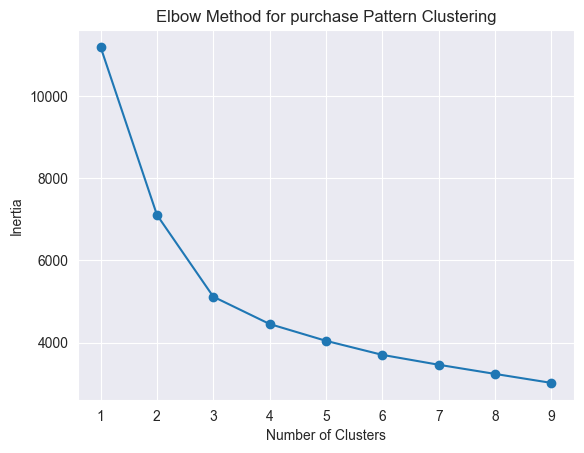

In [29]:
scaler = StandardScaler()
X_behavior = scaler.fit_transform(df[purchase_behavior_features])

inertia = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_behavior)
    inertia.append(kmeans.inertia_)

print(inertia)

plt.plot(range(1, 10), inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for purchase Pattern Clustering')
plt.grid(True)
plt.show()



Number of customers in each cluster:
PurchaseCluster
0    996
1    531
2    713
Name: count, dtype: int64

Percentage of customers in each cluster:
PurchaseCluster
0    44.46
1    23.71
2    31.83
Name: count, dtype: float64 %


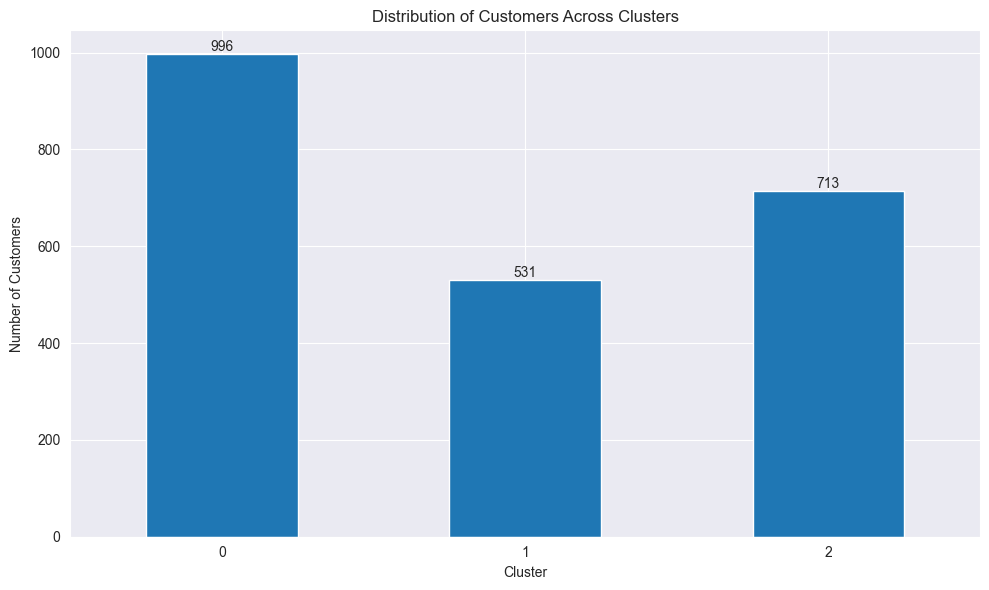

In [30]:
kmeans = KMeans(n_clusters=3, random_state=42)
df['PurchaseCluster'] = kmeans.fit_predict(X_behavior)

# Print cluster distributions 
cluster_counts = df['PurchaseCluster'].value_counts().sort_index()
print("\nNumber of customers in each cluster:")
print(cluster_counts)
print("\nPercentage of customers in each cluster:")
print((cluster_counts / len(df) * 100).round(2), "%")

# Plot distribution
plt.figure(figsize=(10, 6))
cluster_counts.plot(kind='bar')
plt.title('Distribution of Customers Across Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Customers')
plt.xticks(rotation=0)
for i, v in enumerate(cluster_counts):
    plt.text(i, v, str(v), ha='center', va='bottom')
plt.tight_layout()
plt.show()



DEMOGRAPHICS MEANS BY CLUSTER:
                 Education  Total_Dependents  Teenhome  Kidhome
PurchaseCluster                                                
0                     2.32              1.21      0.45     0.76
1                     2.60              1.28      0.86     0.41
2                     2.56              0.35      0.32     0.03


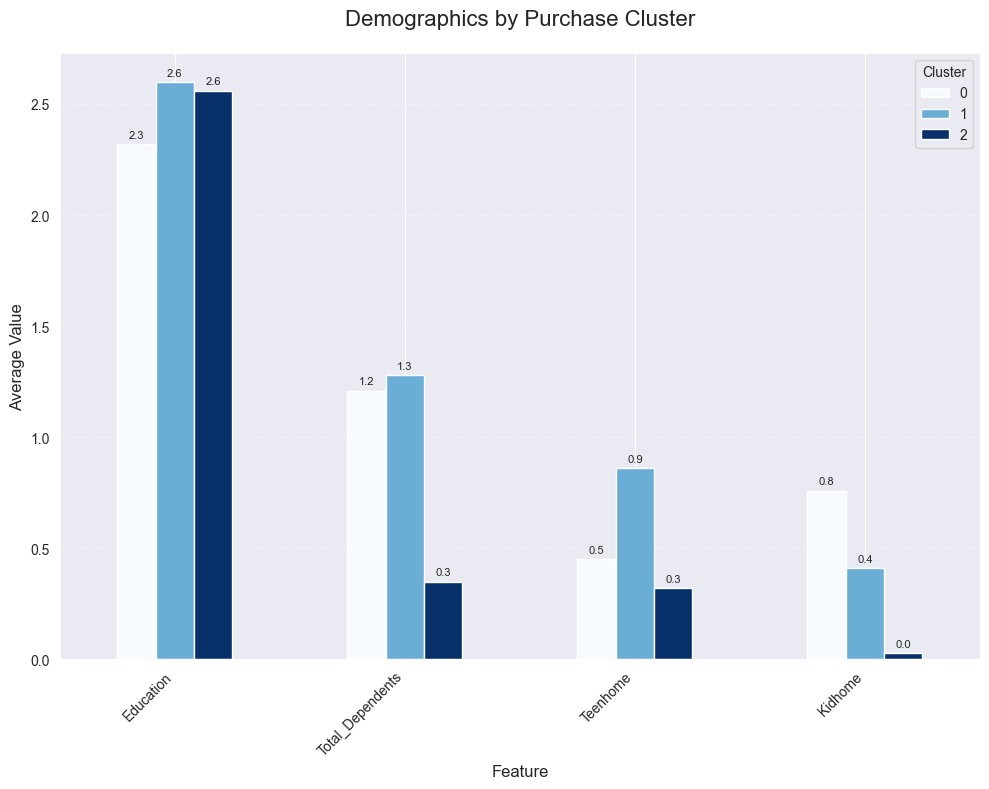


EXPENSES MEANS BY CLUSTER:
                 MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
PurchaseCluster                                                          
0                   48.22       5.21            23.63             7.62   
1                  435.65      21.35           138.26            29.08   
2                  557.33      44.92           338.01            68.59   

                 MntSweetProducts  MntGoldProds  
PurchaseCluster                                  
0                            5.10         15.81  
1                           21.31         53.04  
2                           45.92         62.47  


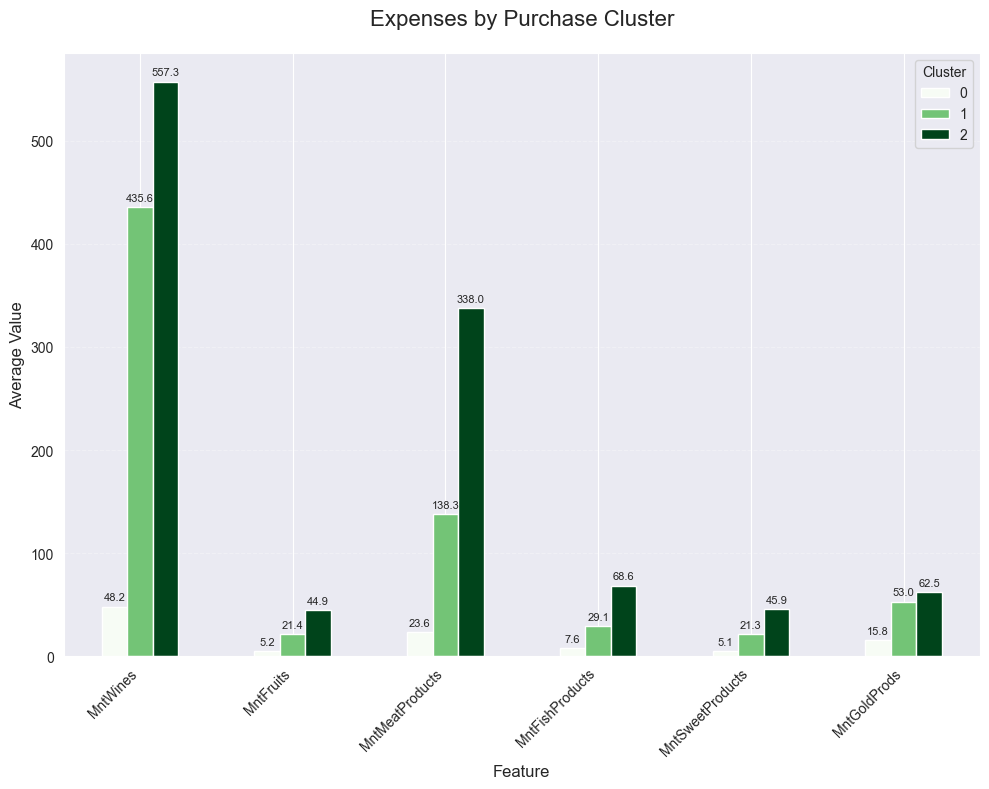


PURCHASE CHANNELS MEANS BY CLUSTER:
                 NumWebPurchases  NumStorePurchases  NumCatalogPurchases  \
PurchaseCluster                                                            
0                           1.99               3.16                 0.54   
1                           6.63               7.28                 2.72   
2                           5.03               8.36                 5.47   

                 NumDealsPurchases  NumWebVisitsMonth  
PurchaseCluster                                        
0                             1.84               6.40  
1                             4.15               6.56  
2                             1.31               2.82  


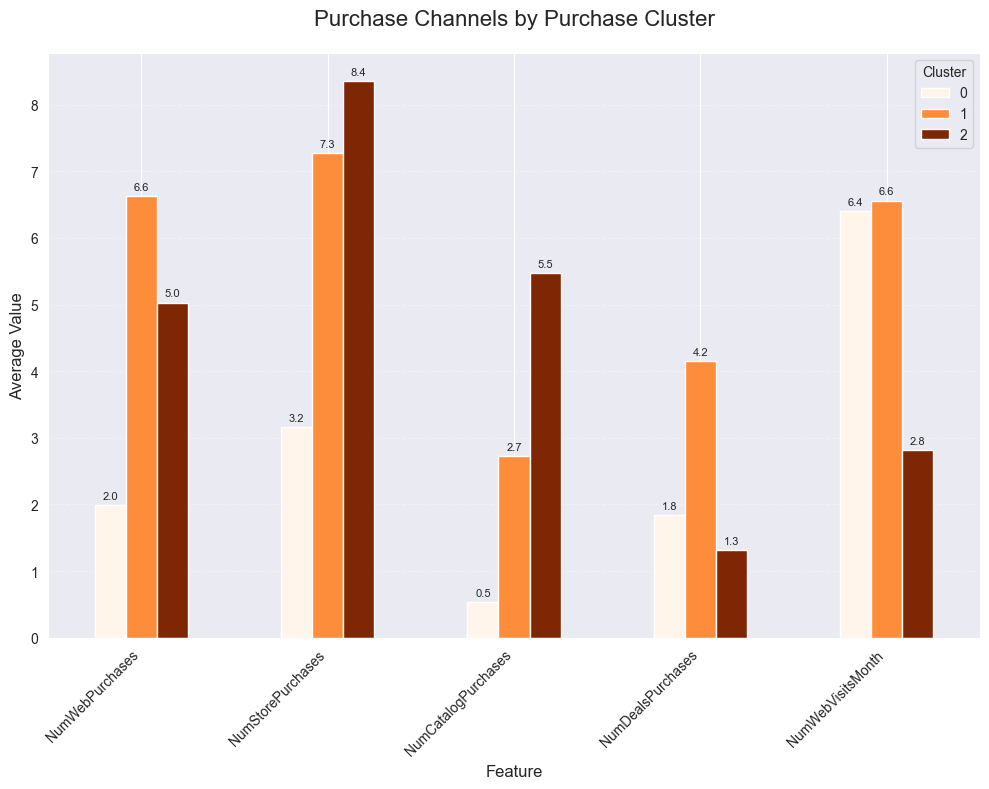


CASH MEANS BY CLUSTER:
                 Total_Spending    Income
PurchaseCluster                          
0                        105.59  35173.56
1                        698.71  54965.43
2                       1117.25  72875.24


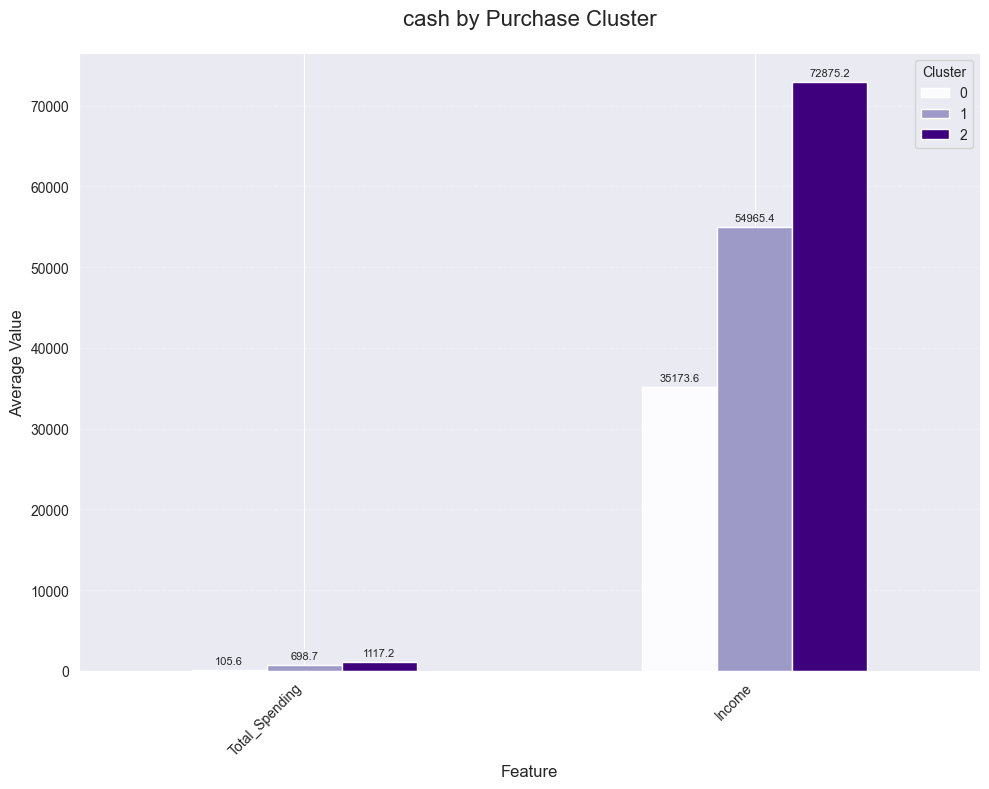


CHANNEL_RATIOS MEANS BY CLUSTER:
                 Web_Ratio  Store_Ratio  Catalog_Ratio  Deals_Ratio
PurchaseCluster                                                    
0                     0.33         0.59           0.08          inf
1                     0.40         0.44           0.16         0.28
2                     0.27         0.44           0.29         0.07


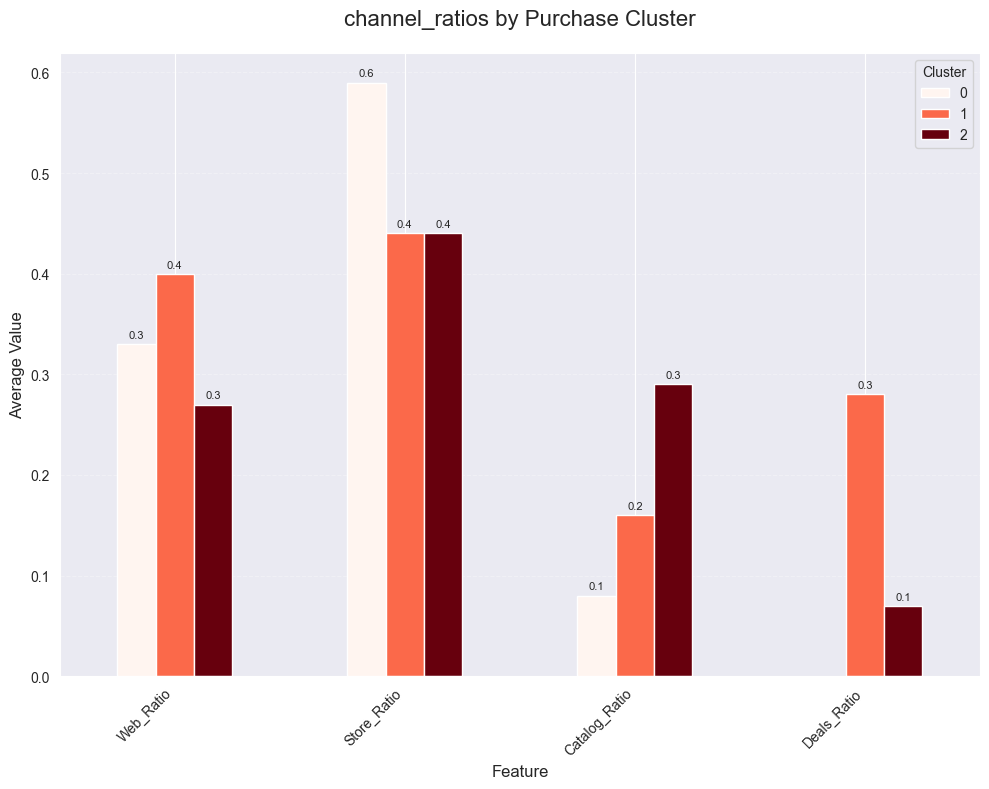


EXPENSE_RATIOS MEANS BY CLUSTER:
                 Wine_Ratio  Fruit_Ratio  Meat_Ratio  Fish_Ratio  Sweet_Ratio  \
PurchaseCluster                                                                 
0                      0.38         0.06        0.24        0.09         0.06   
1                      0.61         0.03        0.20        0.04         0.03   
2                      0.48         0.04        0.30        0.07         0.05   

                 Gold_Ratio  
PurchaseCluster              
0                      0.17  
1                      0.09  
2                      0.06  


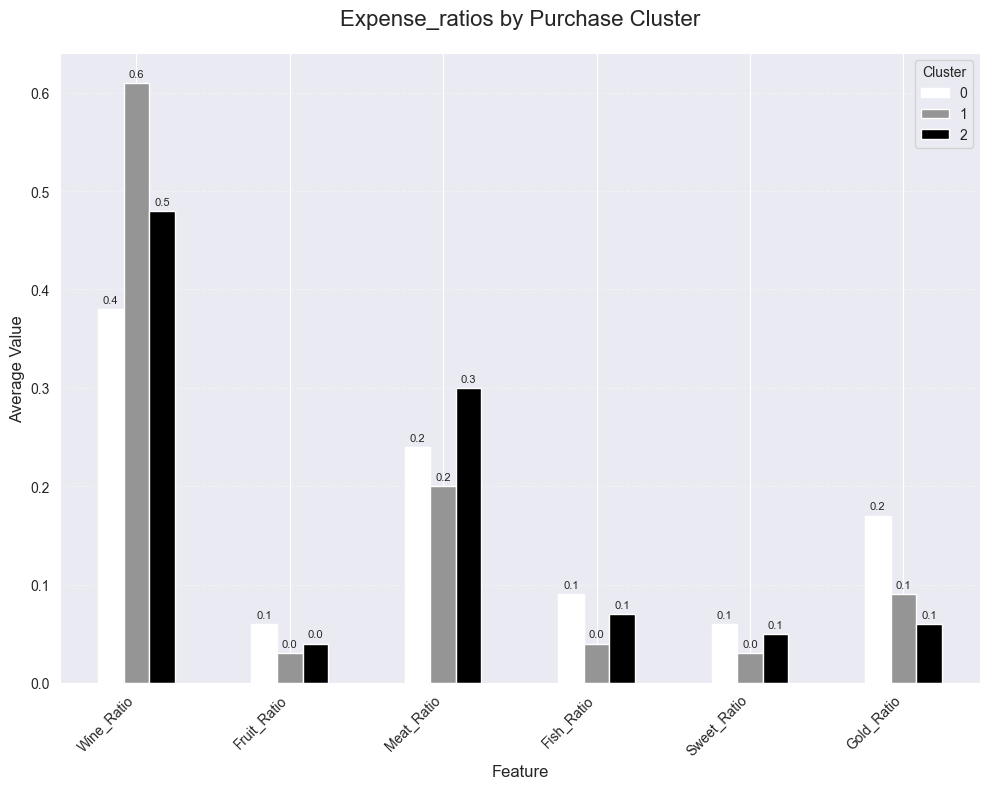

In [31]:

# Organize features by category
feature_categories = {
    'Demographics': [ 'Education', 'Total_Dependents',
                    'Teenhome', 'Kidhome'],
    'Expenses': [ 'MntWines', 'MntFruits', 'MntMeatProducts',
                'MntFishProducts', 'MntSweetProducts', 'MntGoldProds'],
    'Purchase Channels': ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases',
                         'NumDealsPurchases','NumWebVisitsMonth'],
    'cash': ['Total_Spending','Income'],
    'channel_ratios': ['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio'],
    'Expense_ratios': ['Wine_Ratio', 'Fruit_Ratio', 'Meat_Ratio',
                         'Fish_Ratio', 'Sweet_Ratio', 'Gold_Ratio']
}

# Color palettes for each category
color_palettes = {
     'cash': 'Purples'  ,
    'Demographics': 'Blues',

    'Purchase Channels': 'Oranges',

    'channel_ratios': 'Reds',
    'Expenses': 'Greens',
    'Expense_ratios': 'Greys'

}


# Plot each category
for category_name, features in feature_categories.items():
    # Calculate means by cluster
    cluster_means = df.groupby('PurchaseCluster')[features].mean().round(2)
    print(f"\n{category_name.upper()} MEANS BY CLUSTER:")
    print(cluster_means)

    # Create figure with appropriate size based on feature count
    fig_width = min(14, max(10, len(features)))
    fig, ax = plt.subplots(figsize=(fig_width, 8))

    # Plot the transposed data for better visualization
    cluster_means.T.plot(kind='bar', ax=ax, colormap=color_palettes[category_name])

    # Add styling
    plt.title(f'{category_name} by Purchase Cluster', fontsize=16, pad=20)
    plt.ylabel('Average Value', fontsize=12)
    plt.xlabel('Feature', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Cluster', fontsize=10)
    plt.grid(axis='y', linestyle='--', alpha=0.3)

    # Add value labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f', padding=3, fontsize=8)

    plt.tight_layout()
    plt.show()



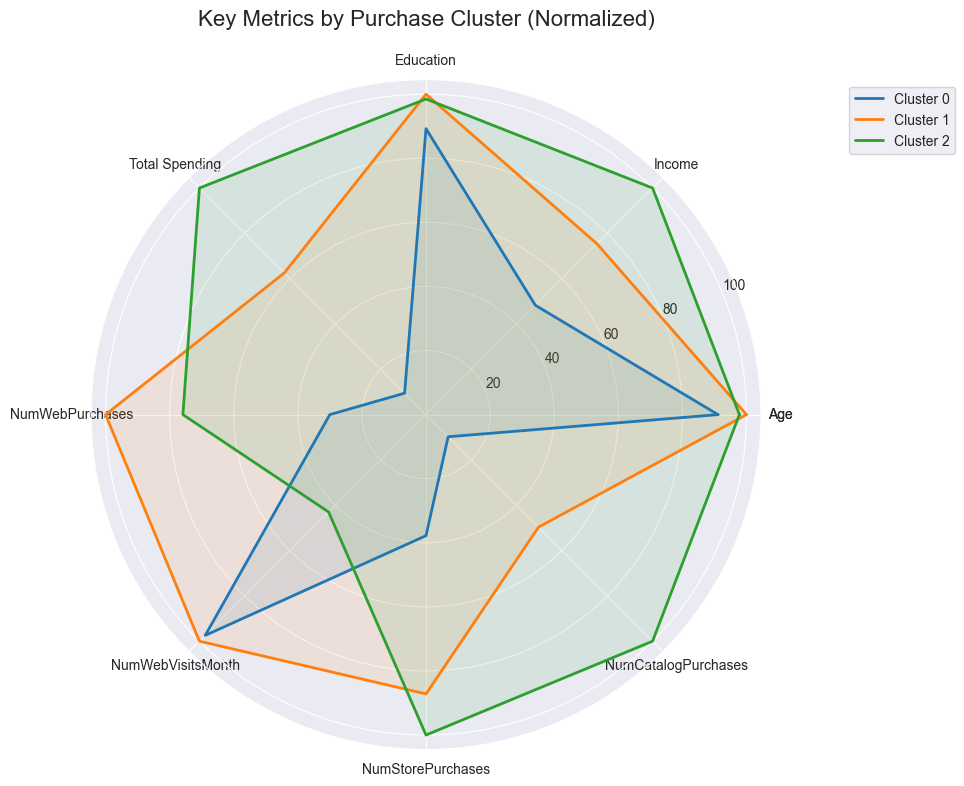

In [32]:
# Create radar chart comparing key metrics across clusters
# Select representative metrics from each category
key_metrics = ['Age', 'Income', 'Education', 'Total_Spending',
              'NumWebPurchases' ,'NumWebVisitsMonth','NumStorePurchases', 'NumCatalogPurchases',]

# Get data and normalize for radar chart
radar_data = df.groupby('PurchaseCluster')[key_metrics].mean()

# Normalize each metric to 0-100 scale
for col in radar_data.columns:
    radar_data[col] = 100 * radar_data[col] / radar_data[col].max()

# Set up radar chart
angles = np.linspace(0, 2*np.pi, len(key_metrics), endpoint=False).tolist()
angles += angles[:1]  # Close the circle

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))

# Plot each cluster
for cluster in radar_data.index:
    values = radar_data.loc[cluster].tolist()
    values += values[:1]  # Close the polygon

    ax.plot(angles, values, linewidth=2, label=f'Cluster {cluster}')
    ax.fill(angles, values, alpha=0.1)

# Add labels
labels = [x.replace('_', ' ') for x in key_metrics]
labels += [labels[0]]  # Complete the circle of labels
ax.set_xticks(angles)
ax.set_xticklabels(labels)

# Customize chart
ax.set_title('Key Metrics by Purchase Cluster (Normalized)', size=16, pad=20)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

plt.tight_layout()
plt.show()

DBSCAN Cluster Counts:
DBSCAN_Cluster
-1      41
 0    2193
 1       6
Name: count, dtype: int64

DBSCAN Cluster Percentages:
Noise points: 1.83%
Cluster 0: 97.9%
Cluster 1: 0.27%


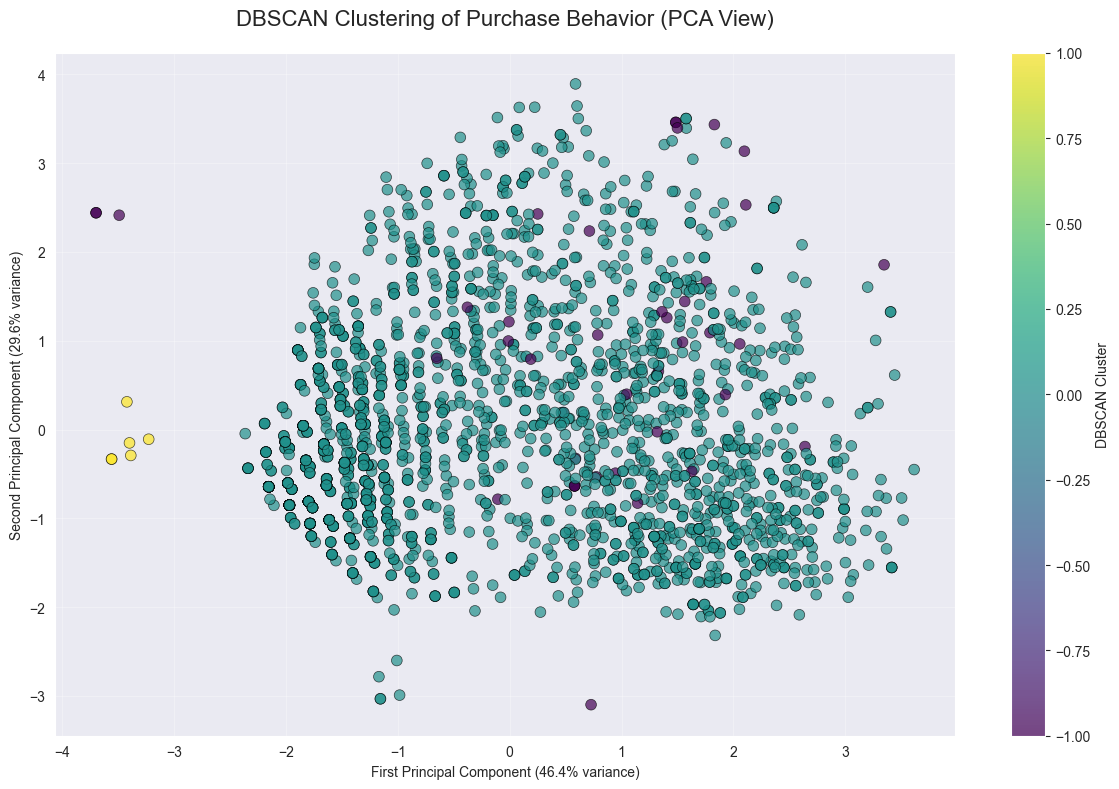


Cross-tabulation (%) of DBSCAN vs. KMeans clusters:
PurchaseCluster       0      1      2
DBSCAN_Cluster                       
-1                12.20  51.22  36.59
 0                44.92  23.26  31.83
 1               100.00   0.00   0.00

Purchase Behavior by DBSCAN Cluster:
                NumDealsPurchases  NumWebPurchases  NumCatalogPurchases  \
DBSCAN_Cluster                                                            
-1                           4.12             5.27                 5.95   
 0                           2.19             4.05                 2.57   
 1                           0.17             0.50                 0.00   

                NumStorePurchases  NumWebVisitsMonth  Total_Purchases  \
DBSCAN_Cluster                                                          
-1                           5.44               5.34            16.66   
 0                           5.81               5.28            12.43   
 1                           0.33              13.0

<Figure size 1400x800 with 0 Axes>

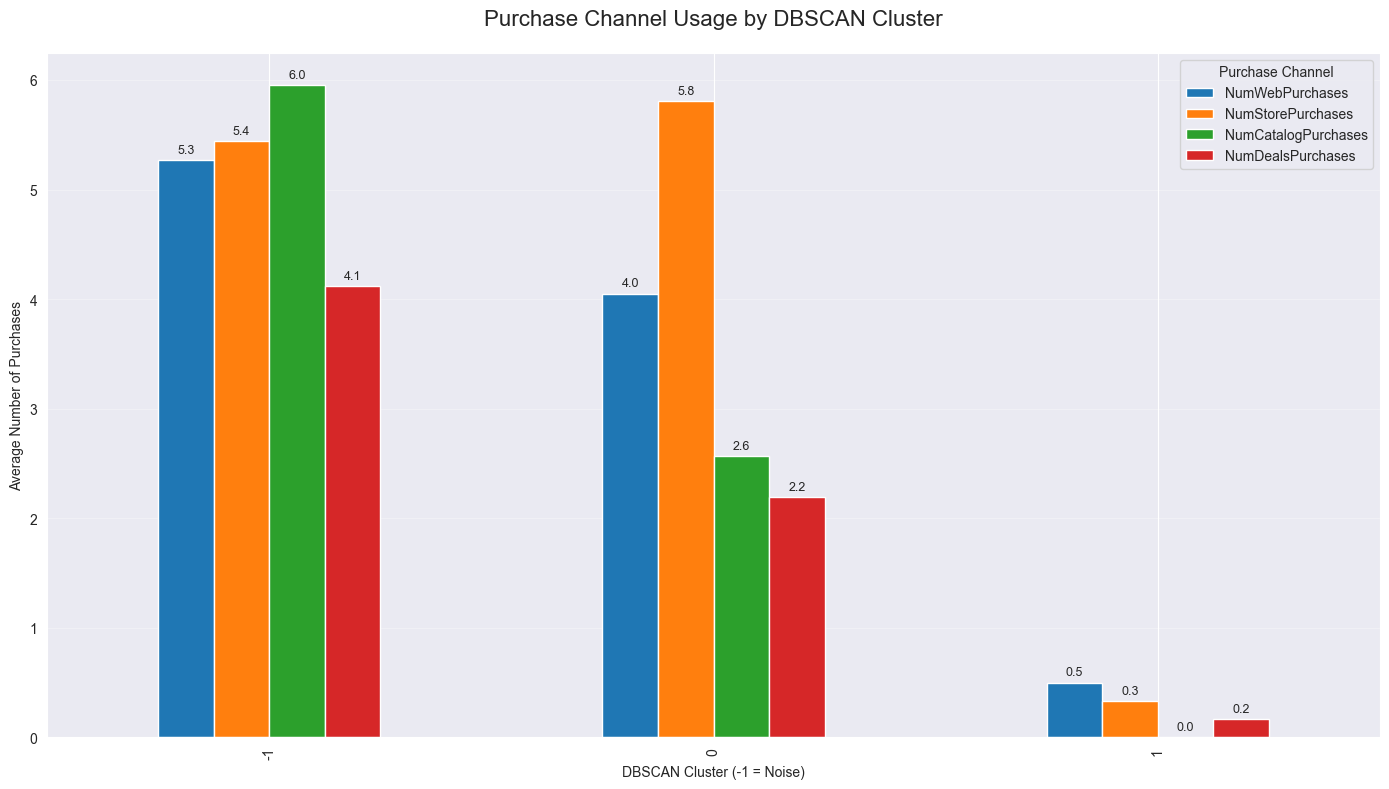


DBSCAN Cluster Characteristics:

Noise Points:

Cluster 0:

Cluster 1:


In [33]:
from sklearn.cluster import DBSCAN


# Apply DBSCAN on the standardized purchase behavior data
# Adjust eps and min_samples based on your data
dbscan = DBSCAN(eps=1.0, min_samples=5)

# Fit DBSCAN model
df['DBSCAN_Cluster'] = dbscan.fit_predict(X_behavior)

# Count clusters (-1 indicates noise points)
cluster_counts = df['DBSCAN_Cluster'].value_counts().sort_index()
print("DBSCAN Cluster Counts:")
print(cluster_counts)

# Calculate percentage of data points in each cluster
total_points = len(df)
cluster_percentages = (cluster_counts / total_points * 100).round(2)
print("\nDBSCAN Cluster Percentages:")
for cluster, percentage in cluster_percentages.items():
    status = "Noise points" if cluster == -1 else f"Cluster {cluster}"
    print(f"{status}: {percentage}%")

# Apply PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_behavior)

# Visualize the DBSCAN clusters with PCA
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['DBSCAN_Cluster'],
                      cmap='viridis', s=60, alpha=0.7, edgecolors='black', linewidth=0.5)
plt.colorbar(scatter, label='DBSCAN Cluster')
plt.title('DBSCAN Clustering of Purchase Behavior (PCA View)', fontsize=16, pad=20)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.1%} variance)')
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Compare DBSCAN clusters with KMeans clusters
cross_tab = pd.crosstab(df['DBSCAN_Cluster'], df['PurchaseCluster'],
                        normalize='index') * 100
print("\nCross-tabulation (%) of DBSCAN vs. KMeans clusters:")
print(cross_tab.round(2))

# Compare purchase patterns across DBSCAN clusters
purchase_metrics = purchase_behavior_features + ['Total_Purchases', 'Income', 'Total_Spending']

# Get cluster summaries, handling -1 (noise) separately
cluster_summary = df.groupby('DBSCAN_Cluster')[purchase_metrics].mean().round(2)
print("\nPurchase Behavior by DBSCAN Cluster:")
print(cluster_summary)

# Visualize key metrics by DBSCAN cluster
metrics_to_plot = ['NumWebPurchases', 'NumStorePurchases', 'NumCatalogPurchases', 'NumDealsPurchases']

plt.figure(figsize=(14, 8))
ax = cluster_summary[metrics_to_plot].plot(kind='bar', figsize=(14, 8))
plt.title('Purchase Channel Usage by DBSCAN Cluster', fontsize=16, pad=20)
plt.xlabel('DBSCAN Cluster (-1 = Noise)')
plt.ylabel('Average Number of Purchases')
plt.legend(title='Purchase Channel')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%.1f', padding=3, fontsize=9)

plt.tight_layout()
plt.show()

# Characterize the clusters based on their features
print("\nDBSCAN Cluster Characteristics:")
for cluster in sorted(df['DBSCAN_Cluster'].unique()):
    if cluster == -1:
        print("\nNoise Points:")
    else:
        print(f"\nCluster {cluster}:")

    # Get top distinctive features
    cluster_data = cluster_summary.loc[cluster]

    # For non-noise clusters, find distinguishing features
    if cluster != -1:
        other_clusters = cluster_summary.drop(cluster)


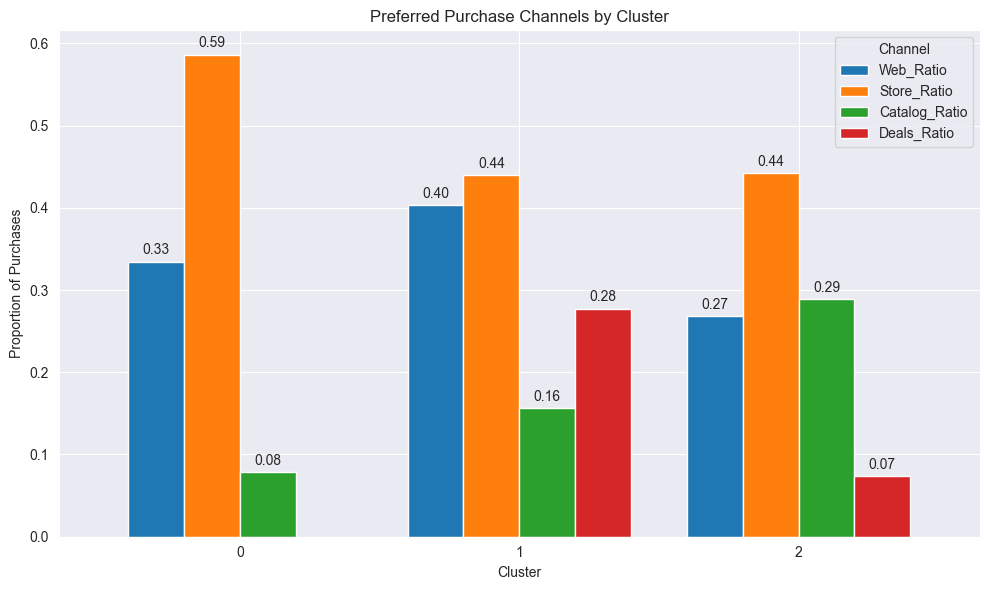

Cluster 0 favorite channel: Deals (inf%)
Cluster 1 favorite channel: Store (43.99%)
Cluster 2 favorite channel: Store (44.20%)


In [34]:


# Get average ratios per cluster
channel_ratios = df.groupby('PurchaseCluster')[['Web_Ratio', 'Store_Ratio', 'Catalog_Ratio', 'Deals_Ratio']].mean()

# Create bar plot
ax = channel_ratios.plot(kind='bar', figsize=(10, 6), width=0.8)
plt.title('Preferred Purchase Channels by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Proportion of Purchases')
plt.legend(title='Channel')
plt.xticks(rotation=0)

# Add value labels on bars
for i in ax.containers:
    ax.bar_label(i, fmt='%.2f', padding=3)

plt.tight_layout()
plt.show()

# Print favorite channel for each cluster
for cluster in range(len(channel_ratios)):
    favorite_channel = channel_ratios.iloc[cluster].idxmax()
    ratio = channel_ratios.iloc[cluster][favorite_channel]
    print(f"Cluster {cluster} favorite channel: {favorite_channel.replace('_Ratio', '')} ({ratio:.2%})")


In [36]:
# Save the KMeans model and cluster labels
os.makedirs('models', exist_ok=True)
joblib.dump(kmeans, 'models/purchase_clusters.joblib')

# Save cluster assignments to CSV 
df.to_csv('../featured_customer_segmentation_with_clusters.csv', index=False)
print("Purchase clusters model and data saved successfully")


Purchase clusters model and data saved successfully
